In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## Load the Fashion MNIST dataset

In [2]:
(train_images, train_labels), (_,_) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

## Preprocess and normalize the image data

In [4]:
train_images = train_images.reshape(train_images.shape[0],28,28,1)
train_images = (train_images-127.5)/127.5

## Set constants for training

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

## Create a TensorFlow dataset

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Define the generator model

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias = False, input_shape = (100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias = False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias = False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias = False,activation='tanh'))
    assert model.output_shape == (None,28,28,1)
    return model

## Generate a sample image from the generator

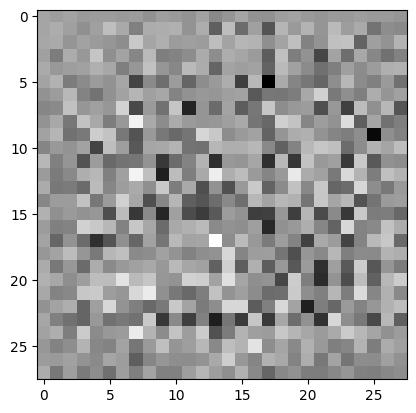

In [8]:
generator = make_generator_model()
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## Define the discriminator model

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

## Check the discriminator's decision on the generated image

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00147444]], shape=(1, 1), dtype=float32)


## Define loss functions

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    return (real_loss+fake_loss)

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

## Define optimizers

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Set the number of training epochs and noise dimension

In [15]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 25
seed = tf.random.normal([num_examples_to_generate,noise_dim])

## Training step function

In [16]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


## Training loop

In [17]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## Function to generate and save images

In [18]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(5, 5))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the GAN

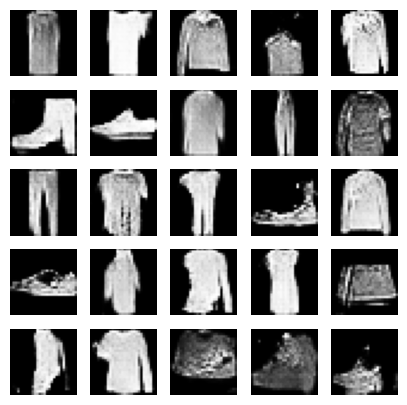

In [19]:
train(train_dataset, EPOCHS)

## Create an animated GIF from the generated images

In [22]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

C:\Users\gunji\AppData\Local\Temp\ipykernel_18248\1116088281.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\gunji\AppData\Local\Temp\ipykernel_18248\1116088281.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Embed the generated GIF


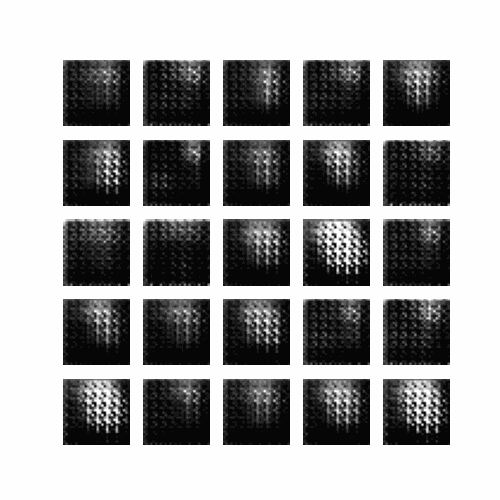

In [21]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)